**Importing Libraries:**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

**Importing data:**

In [ ]:
plant1 = pd.read_csv('plant1_data.csv')
plant2 = pd.read_csv('plant2_data.csv')

**Converting DATE_TIME column to date-time data type:**

In [ ]:
plant1['DATE_TIME'] = pd.to_datetime(plant1['DATE_TIME'])
plant1.set_index('DATE_TIME', inplace=True)

In [ ]:
plant2['DATE_TIME'] = pd.to_datetime(plant2['DATE_TIME'])
plant2.set_index('DATE_TIME', inplace=True)

**Plotting the correlation heatmap:**

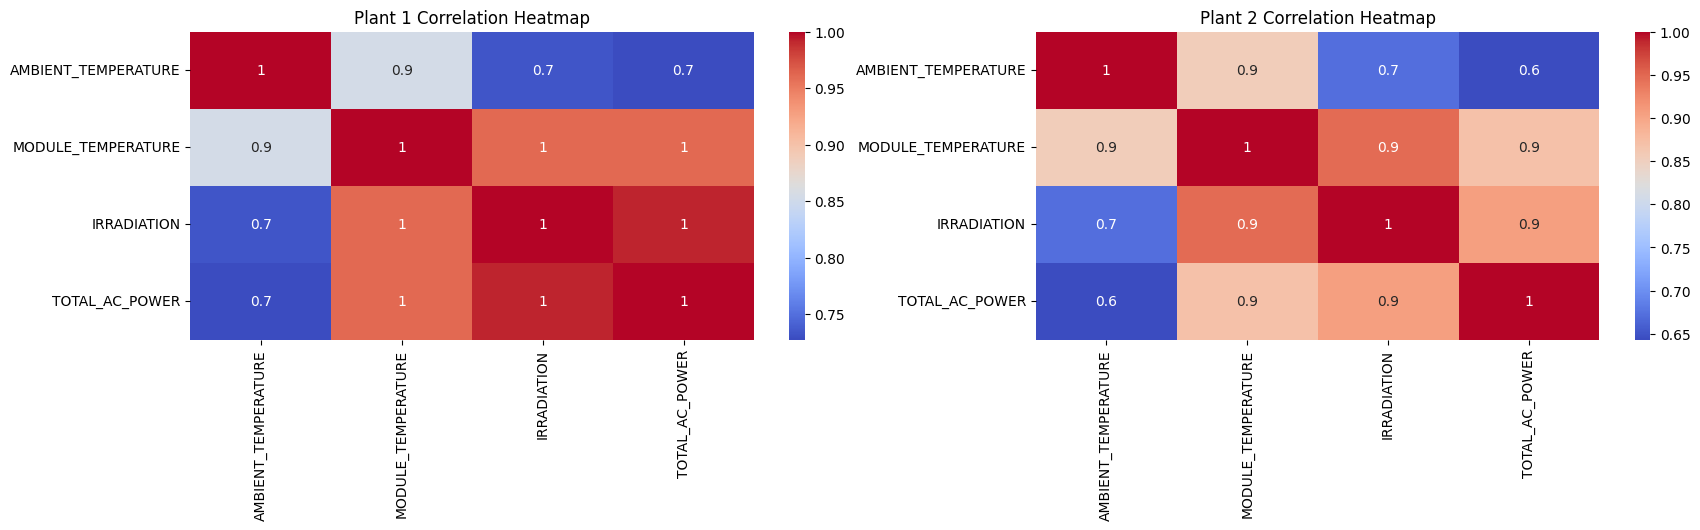

In [ ]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
sns.heatmap(plant1.corr(), annot=True, fmt='.1g', cmap='coolwarm').set(title="Plant 1 Correlation Heatmap")

plt.subplot(1, 2, 2)
sns.heatmap(plant2.corr(), annot=True, fmt='.1g', cmap='coolwarm').set(title="Plant 2 Correlation Heatmap")

plt.show()


***Observation:***

The independent features are strongly positively correlated to each other.

####**Building the model using all weather features:**

In [ ]:
X1 = plant1.drop('TOTAL_AC_POWER', axis=1)
y1 = plant1['TOTAL_AC_POWER']

X2 = plant2.drop('TOTAL_AC_POWER', axis=1)
y2 = plant2['TOTAL_AC_POWER']

In [ ]:
cutoff_date = '2020-06-07' # reserving the data after this date for testing

# for plant 1
X1_train = X1[X1.index < cutoff_date]
y1_train = y1[y1.index < cutoff_date]
X1_test = X1[X1.index >= cutoff_date]
y1_test = y1[y1.index >= cutoff_date]

# for plant 2
X2_train = X2[X2.index < cutoff_date]
y2_train = y2[y2.index < cutoff_date]
X2_test = X2[X2.index >= cutoff_date]
y2_test = y2[y2.index >= cutoff_date]

In [ ]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# the scoring function (RMSE)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

**Defining the pipelines:**

In [ ]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [ ]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso())
])

In [ ]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

In [ ]:
decision_tree_pipeline = Pipeline([
    ('regressor', DecisionTreeRegressor())
])

In [ ]:
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SVR())
])


In [ ]:
xgb_pipeline = Pipeline([
    ('regressor', XGBRegressor())
])


In [ ]:
models = {
    'Linear Regression': lr_pipeline,
    'Lasso Regression': lasso_pipeline,
    'Ridge Regression': ridge_pipeline,
    'Decision Tree': decision_tree_pipeline,
    'SVR': svr_pipeline,
    'XGBRegressor': xgb_pipeline
}

**Evaluating the models:**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, plant_name):
    cv_rmse = []
    for train_index, val_index in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(X_train_cv, y_train_cv)
        y_val_pred = model.predict(X_val_cv)
        mse = mean_squared_error(y_val_cv, y_val_pred)
        cv_rmse.append(np.sqrt(mse))

    avg_cv_rmse = np.mean(cv_rmse)

    # fit the training data and test on the testing data
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{model_name} for {plant_name}")
    print(f"  Average Cross-Validation RMSE: {avg_cv_rmse:.2f}")
    print(f"  Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.3f}\n")

In [ ]:
# Evaluate each model for Plant 1 and Plant 2
for name, model in models.items():
    evaluate_model(model, X1_train, y1_train, X1_test, y1_test, name, "Plant 1")
    evaluate_model(model, X2_train, y2_train, X2_test, y2_test, name, "Plant 2")

Linear Regression for Plant 1
  Average Cross-Validation RMSE: 1134.60
  Test RMSE: 878.15, MAE: 424.31, R²: 0.989

Linear Regression for Plant 2
  Average Cross-Validation RMSE: 2574.69
  Test RMSE: 2711.38, MAE: 1772.62, R²: 0.753

Lasso Regression for Plant 1
  Average Cross-Validation RMSE: 1134.75
  Test RMSE: 878.53, MAE: 424.42, R²: 0.989

Lasso Regression for Plant 2
  Average Cross-Validation RMSE: 2574.00
  Test RMSE: 2710.55, MAE: 1771.79, R²: 0.753

Ridge Regression for Plant 1
  Average Cross-Validation RMSE: 1130.00
  Test RMSE: 879.86, MAE: 426.18, R²: 0.989

Ridge Regression for Plant 2
  Average Cross-Validation RMSE: 2569.33
  Test RMSE: 2712.68, MAE: 1773.69, R²: 0.753

Decision Tree for Plant 1
  Average Cross-Validation RMSE: 1118.78
  Test RMSE: 1088.09, MAE: 489.39, R²: 0.983

Decision Tree for Plant 2
  Average Cross-Validation RMSE: 1938.39
  Test RMSE: 2347.76, MAE: 964.82, R²: 0.815

SVR for Plant 1
  Average Cross-Validation RMSE: 10418.28
  Test RMSE: 9480.

***Observation:***

For both plants, XGBRegressor seems to work best.

Let's see what the feature importances are -

In [ ]:
model1 = XGBRegressor()
model1.fit(X1_train, y1_train)

pred1 = model1.predict(X1_test)
print(f"  Test RMSE: {np.sqrt(mean_squared_error(y1_test, pred1)):.2f}, MAE: {mean_absolute_error(y1_test, pred1):.2f}, R²: {r2_score(y1_test, pred1):.3f}\n")

  Test RMSE: 912.15, MAE: 413.34, R²: 0.988



               Feature  Importance
0  AMBIENT_TEMPERATURE    0.001685
1   MODULE_TEMPERATURE    0.001823
2          IRRADIATION    0.996493


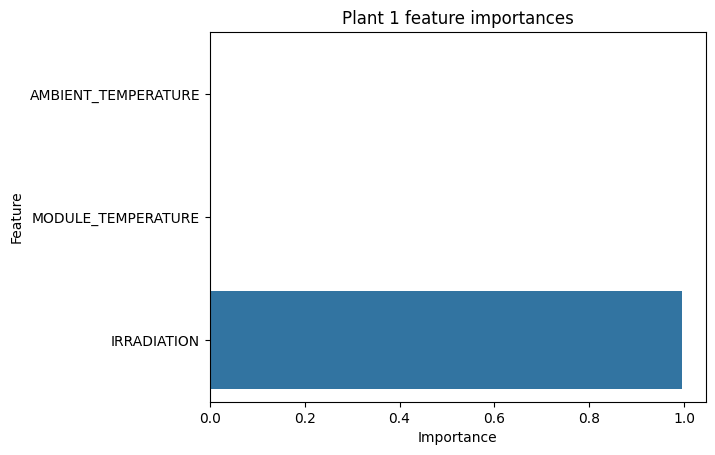

In [ ]:
feature_importance1_df = pd.DataFrame({
    'Feature': X1_train.columns,
    'Importance': model1.feature_importances_
})

print(feature_importance1_df)
sns.barplot(x='Importance', y='Feature', data=feature_importance1_df).set(title='Plant 1 feature importances')
plt.show()




In [ ]:
model2 = XGBRegressor()
model2.fit(X2_train, y2_train)

pred2 = model2.predict(X2_test)
print(f"  Test RMSE: {np.sqrt(mean_squared_error(y2_test, pred2)):.2f}, MAE: {mean_absolute_error(y2_test, pred2):.2f}, R²: {r2_score(y2_test, pred2):.2f}\n")

  Test RMSE: 2102.76, MAE: 887.27, R²: 0.85



               Feature  Importance
0  AMBIENT_TEMPERATURE    0.011905
1   MODULE_TEMPERATURE    0.012226
2          IRRADIATION    0.975869


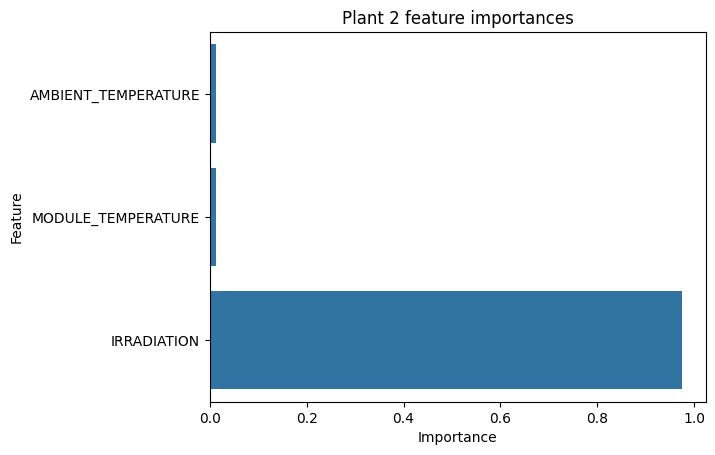

In [ ]:
feature_importance2_df = pd.DataFrame({
    'Feature': X2_train.columns,
    'Importance': model2.feature_importances_
})
print(feature_importance2_df)
sns.barplot(x='Importance', y='Feature', data=feature_importance2_df).set(title='Plant 2 feature importances')
plt.show()


***Observation:***

As is apparent, for plant 1 only the irradiation feature is contributing to the prediction of AC Power, similarly with plant 2 also Irradiation is the dominant feature.

####**Using only Irradiation as a feature for the model:**

In [ ]:
X1 = plant1[['IRRADIATION']]
y1 = plant1['TOTAL_AC_POWER']

X2 = plant2[['IRRADIATION']]
y2 = plant2['TOTAL_AC_POWER']

X1_train = X1[X1.index < cutoff_date] # cutoff date = '2020-06-07'
y1_train = y1[y1.index < cutoff_date]
X1_test = X1[X1.index >= cutoff_date]
y1_test = y1[y1.index >= cutoff_date]

X2_train = X2[X2.index < cutoff_date]
y2_train = y2[y2.index < cutoff_date]
X2_test = X2[X2.index >= cutoff_date]
y2_test = y2[y2.index >= cutoff_date]

In [ ]:
# Evaluate each model for Plant 1 and Plant 2
for name, model in models.items():
    evaluate_model(model, X1_train, y1_train, X1_test, y1_test, name, "Plant 1")
    evaluate_model(model, X2_train, y2_train, X2_test, y2_test, name, "Plant 2")

Linear Regression for Plant 1
  Average Cross-Validation RMSE: 1210.01
  Test RMSE: 905.53, MAE: 414.32, R²: 0.988

Linear Regression for Plant 2
  Average Cross-Validation RMSE: 2567.31
  Test RMSE: 2631.92, MAE: 1804.57, R²: 0.767

Lasso Regression for Plant 1
  Average Cross-Validation RMSE: 1210.09
  Test RMSE: 905.50, MAE: 413.82, R²: 0.988

Lasso Regression for Plant 2
  Average Cross-Validation RMSE: 2567.25
  Test RMSE: 2631.95, MAE: 1804.88, R²: 0.767

Ridge Regression for Plant 1
  Average Cross-Validation RMSE: 1211.73
  Test RMSE: 905.41, MAE: 412.28, R²: 0.988

Ridge Regression for Plant 2
  Average Cross-Validation RMSE: 2565.75
  Test RMSE: 2632.00, MAE: 1805.35, R²: 0.767

Decision Tree for Plant 1
  Average Cross-Validation RMSE: 1070.68
  Test RMSE: 919.01, MAE: 436.73, R²: 0.988

Decision Tree for Plant 2
  Average Cross-Validation RMSE: 1787.38
  Test RMSE: 2150.66, MAE: 899.44, R²: 0.845

SVR for Plant 1
  Average Cross-Validation RMSE: 10301.95
  Test RMSE: 9223.6

***Observation:***

Using only Irradiation does lead to a slight improvement across all the metrics.

####**Creating and Using Time Series Features for Prediction:**

In [ ]:
def create_datetime_features(df):
  df['hour'] = df.index.hour
  df['day_of_week'] = df.index.dayofweek
  df['month'] = df.index.month
  return df

In [ ]:
new_plant1 = create_datetime_features(plant1)
new_plant2 = create_datetime_features(plant2)

In [ ]:
X1 = new_plant1[['IRRADIATION', 'hour', 'day_of_week', 'month']]
y1 = new_plant1['TOTAL_AC_POWER']

X2 = new_plant2[['IRRADIATION', 'hour', 'day_of_week', 'month']]
y2 = new_plant2['TOTAL_AC_POWER']

X1_train = X1[X1.index < cutoff_date] # cutoff date = '2020-06-07'
y1_train = y1[y1.index < cutoff_date]
X1_test = X1[X1.index >= cutoff_date]
y1_test = y1[y1.index >= cutoff_date]


X2_train = X2[X2.index < cutoff_date]
y2_train = y2[y2.index < cutoff_date]
X2_test = X2[X2.index >= cutoff_date]
y2_test = y2[y2.index >= cutoff_date]

In [ ]:
model1 = XGBRegressor()
model1.fit(X1_train, y1_train)

pred1 = model1.predict(X1_test)
print(f"  Test RMSE: {np.sqrt(mean_squared_error(y1_test, pred1)):.2f}, MAE: {mean_absolute_error(y1_test, pred1):.2f}, R²: {r2_score(y1_test, pred1):.3f}\n")

  Test RMSE: 986.54, MAE: 416.52, R²: 0.986



       Feature  Importance
0  IRRADIATION    0.989819
1         hour    0.004110
2  day_of_week    0.002098
3        month    0.003973


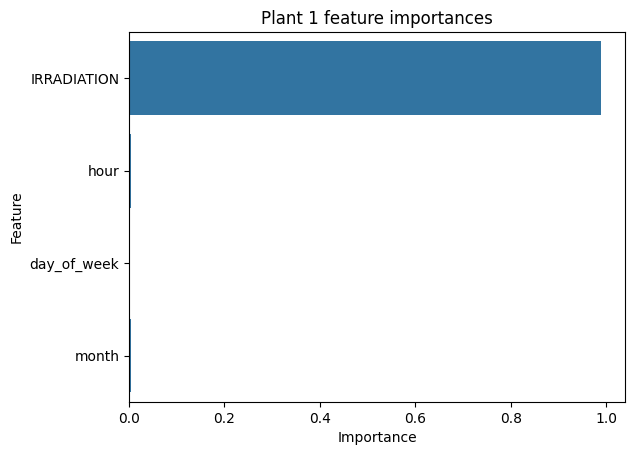

In [ ]:
feature_importance1_df = pd.DataFrame({
    'Feature': X1_train.columns,
    'Importance': model1.feature_importances_
})

print(feature_importance1_df)
sns.barplot(x='Importance', y='Feature', data=feature_importance1_df).set(title='Plant 1 feature importances')
plt.show()




In [ ]:
model2 = XGBRegressor()
model2.fit(X2_train, y2_train)

pred2 = model2.predict(X2_test)
print(f"  Test RMSE: {np.sqrt(mean_squared_error(y2_test, pred2)):.2f}, MAE: {mean_absolute_error(y2_test, pred2):.2f}, R²: {r2_score(y2_test, pred2):.2f}\n")

  Test RMSE: 2094.84, MAE: 903.29, R²: 0.85



       Feature  Importance
0  IRRADIATION    0.924626
1         hour    0.019283
2  day_of_week    0.019207
3        month    0.036884


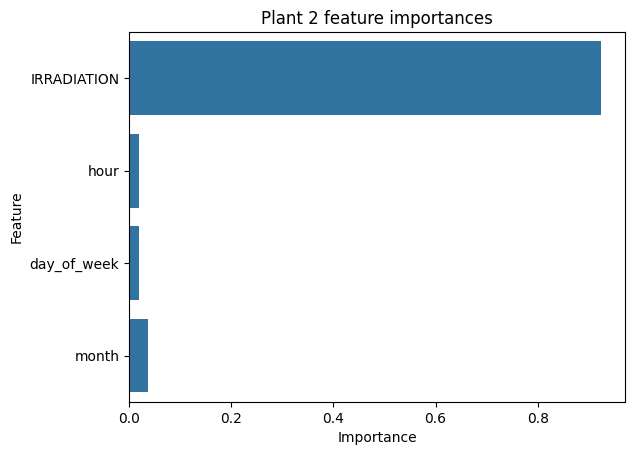

In [ ]:
feature_importance2_df = pd.DataFrame({
    'Feature': X2_train.columns,
    'Importance': model2.feature_importances_
})
print(feature_importance2_df)
sns.barplot(x='Importance', y='Feature', data=feature_importance2_df).set(title='Plant 2 feature importances')
plt.show()


***Observation:***

The time series features are not contributing to the prediction in Plant 1 but they are slightly contributing in Plant 2 (especially month).

**So we'll be using the XGBRegressor trained in just Irradiation for plant 1 and for time series features and irradiation for plant 2 for deployment.**

#### **Final Model:**



In [ ]:
X1 = plant1[['IRRADIATION']]
y1 = plant1['TOTAL_AC_POWER']

X2 = new_plant2[['IRRADIATION', 'hour', 'day_of_week', 'month']]
y2 = new_plant2['TOTAL_AC_POWER']

X1_train = X1[X1.index < cutoff_date]
y1_train = y1[y1.index < cutoff_date]
X1_test = X1[X1.index >= cutoff_date]
y1_test = y1[y1.index >= cutoff_date]

X2_train = X2[X2.index < cutoff_date]
y2_train = y2[y2.index < cutoff_date]
X2_test = X2[X2.index >= cutoff_date]
y2_test = y2[y2.index >= cutoff_date]

In [ ]:
# creating scalers for each plant
scaler1 = StandardScaler()
scaler2 = StandardScaler()

# fit and transform the training data, and transform the test data
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

**Hyperparameter Tuning:**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

In [ ]:
# create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

Plant 1:

In [ ]:
# creating the XGBRegressor model
model1 = XGBRegressor()

# setting up GridSearchCV with TimeSeriesSplit
grid_search1 = GridSearchCV(estimator=model1,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=tscv,
                           verbose=1,
                           n_jobs=-1)

# fit GridSearchCV
grid_search1.fit(X1_train_scaled, y1_train)

# get the best parameters
best_params1 = grid_search1.best_params_
print(f"Best Parameters: {best_params1}")

# get the best model
best_model1 = grid_search1.best_estimator_

# predict with the best model
pred_best1 = best_model1.predict(X1_test_scaled)

# print the evaluation metrics
print(f"RMSE: {np.sqrt(mean_squared_error(y1_test, pred_best1)):.2f}")
print(f"MAE: {mean_absolute_error(y1_test, pred_best1):.2f}")
print(f"R²: {r2_score(y1_test, pred_best1):.3f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
RMSE: 824.97
MAE: 374.80
R²: 0.990


Plant 2:

In [ ]:
# creating the XGBRegressor model
model2 = XGBRegressor()

# setting up GridSearchCV with TimeSeriesSplit
grid_search2 = GridSearchCV(estimator=model2,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=tscv,
                           verbose=1,
                           n_jobs=-1)

# fit GridSearchCV
grid_search2.fit(X2_train_scaled, y2_train)

# get the best parameters
best_params2 = grid_search2.best_params_
print(f"Best Parameters: {best_params2}")

# get the best model
best_model2 = grid_search2.best_estimator_

# predict with the best model
pred_best2 = best_model2.predict(X2_test_scaled)

# print the evaluation metrics
print(f"RMSE: {np.sqrt(mean_squared_error(y2_test, pred_best2)):.2f}")
print(f"MAE: {mean_absolute_error(y2_test, pred_best2):.2f}")
print(f"R²: {r2_score(y2_test, pred_best2):.3f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
RMSE: 1788.92
MAE: 905.20
R²: 0.893


**Visualizing the Results:**

In [ ]:
results_df1 = pd.DataFrame({
    'Date': y1_test.index,
    'Actual': y1_test,
    'Predicted': pred_best1
})

results_df1.set_index('Date', inplace=True)

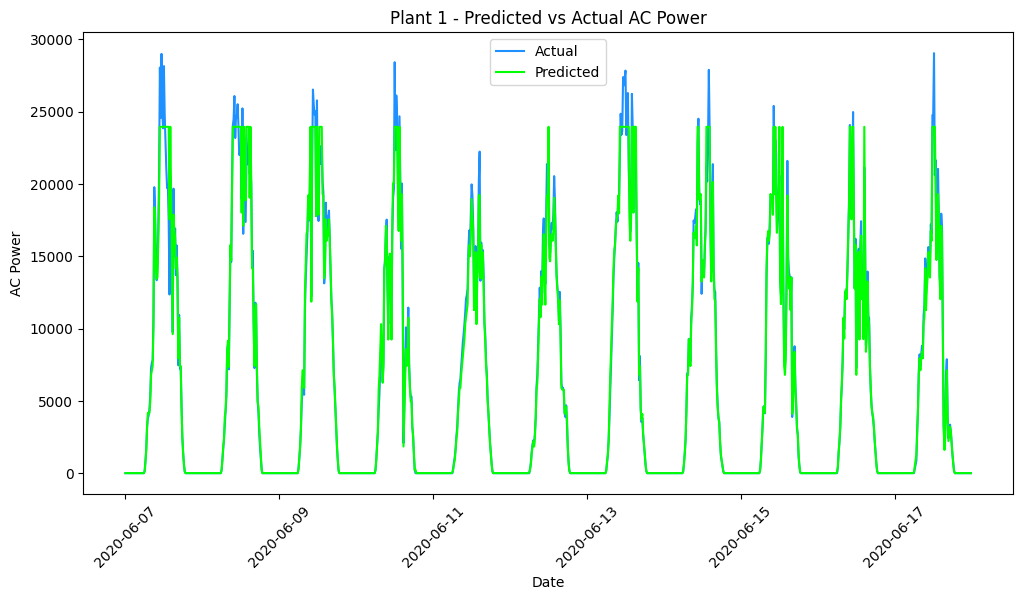

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=results_df1.index, y='Actual', data=results_df1, label='Actual', color='dodgerblue')
sns.lineplot(x=results_df1.index, y='Predicted', data=results_df1, label='Predicted', color='lime')
plt.title('Plant 1 - Predicted vs Actual AC Power')
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.xticks(rotation=45)
plt.show()

In [ ]:
results_df2 = pd.DataFrame({
    'Date': y2_test.index,
    'Actual': y2_test,
    'Predicted': pred_best2
})

results_df2.set_index('Date', inplace=True)

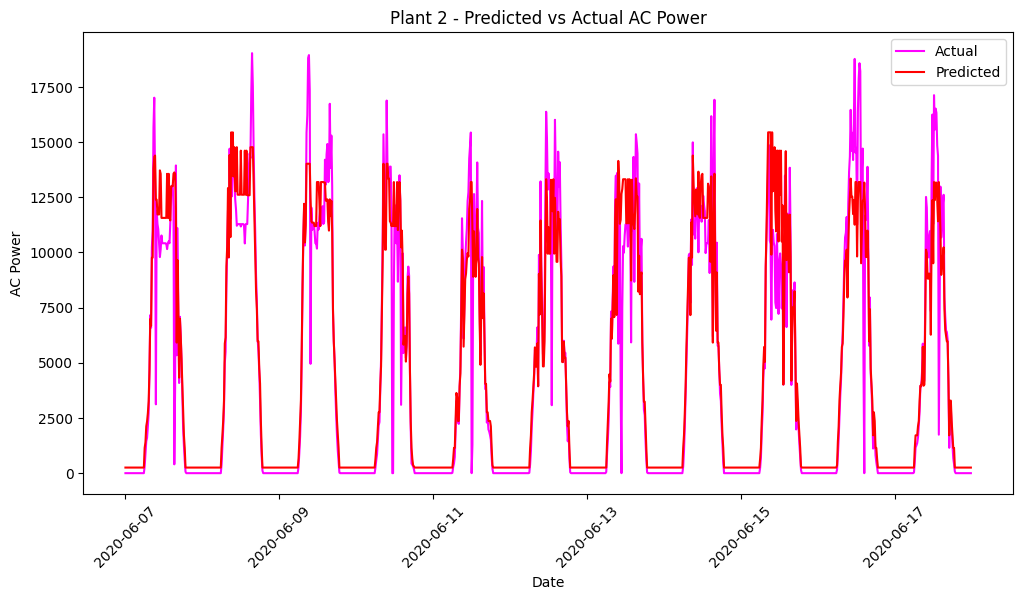

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=results_df2.index, y='Actual', data=results_df2, label='Actual', color='fuchsia')
sns.lineplot(x=results_df2.index, y='Predicted', data=results_df2, label='Predicted', color='red')
plt.title('Plant 2 - Predicted vs Actual AC Power')
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.xticks(rotation=45)
plt.show()

**Saving the Models and the Scalers:**

In [ ]:
import pickle


with open('best_model1.pkl', 'wb') as file:
    pickle.dump(best_model1, file)

with open('best_model2.pkl', 'wb') as file:
    pickle.dump(best_model2, file)

In [ ]:
with open('scaler1.pkl', 'wb') as file:
    pickle.dump(scaler1, file)

with open('scaler2.pkl', 'wb') as file:
    pickle.dump(scaler2, file)